# EDA Notebook
In this notebook we conduct exploratory data analysis to our dataset to better understand the nature of our data and insights for machine learning efforts.

In [40]:
import pandas as pd
data = pd.read_csv('../data/cleaned_data_v2.csv')

### Correlation of survey answers

sns heatmap

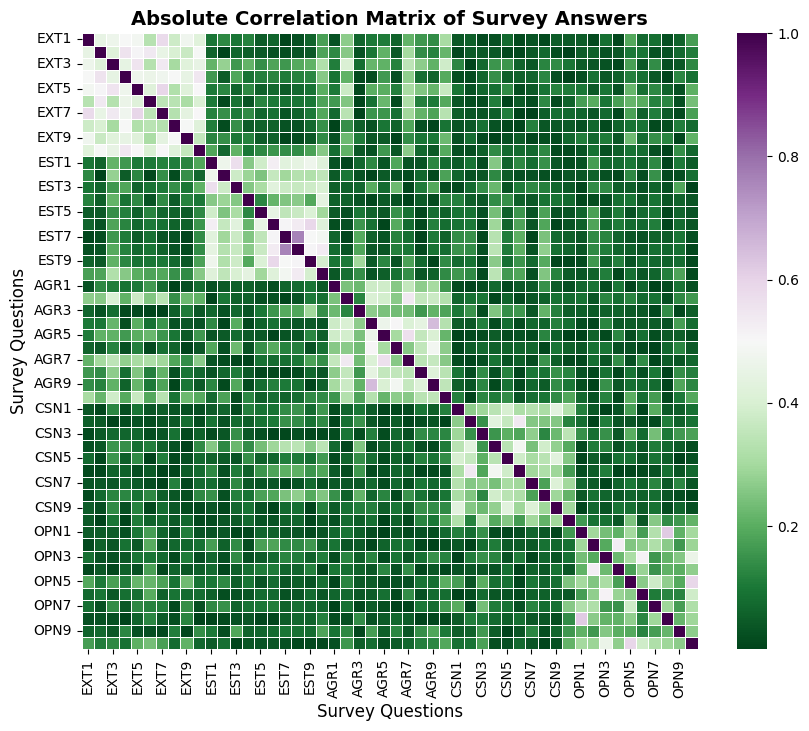

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load survey answer column names
survey_answer_cols = pd.read_excel('../scoring/scoring.xlsx')['id'].tolist()

# Compute correlation matrix and take absolute values
answer_matrix_corr = data[survey_answer_cols].corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(answer_matrix_corr, cmap='PRGn_r', linewidths=0.5, cbar=True, square=True)


# Add title and labels
plt.title("Absolute Correlation Matrix of Survey Answers", fontsize=14, fontweight='bold')
plt.xlabel("Survey Questions", fontsize=12)
plt.ylabel("Survey Questions", fontsize=12)

# Show plot
plt.show()


top correlations

In [42]:
import pandas as pd
import numpy as np
from tabulate import tabulate

# Load scoring table
scoring = pd.read_excel('../scoring/scoring.xlsx')

# Create a mapping from column 'id' to 'trait'
trait_map = dict(zip(scoring['id'], scoring['trait']))

# Load survey answer column names
survey_answer_cols = scoring['id'].tolist()

# Compute absolute correlation matrix
answer_matrix_corr = data[survey_answer_cols].corr().abs()

# Extract upper triangle of the correlation matrix without the diagonal
corr_unstacked = answer_matrix_corr.where(np.triu(np.ones(answer_matrix_corr.shape), k=1).astype(bool))

# Convert to a DataFrame and reset index
corr_pairs = corr_unstacked.stack().reset_index()
corr_pairs.columns = ['col1', 'col2', 'correlation']

# Extract category (first 3 letters of column names)
corr_pairs['category1'] = corr_pairs['col1'].str[:3]
corr_pairs['category2'] = corr_pairs['col2'].str[:3]

# Map column names to trait names
corr_pairs['trait1'] = corr_pairs['col1'].map(trait_map)
corr_pairs['trait2'] = corr_pairs['col2'].map(trait_map)

# Split into same-category and different-category correlations
same_category = corr_pairs[corr_pairs['category1'] == corr_pairs['category2']]
diff_category = corr_pairs[corr_pairs['category1'] != corr_pairs['category2']]

# Get top 5 highest correlations in each category
top5_same = same_category.nlargest(5, 'correlation')
top5_diff = diff_category.nlargest(5, 'correlation')

# Add 'id' values for reference
top5_same['id1'] = top5_same['col1']
top5_same['id2'] = top5_same['col2']
top5_diff['id1'] = top5_diff['col1']
top5_diff['id2'] = top5_diff['col2']

# Select and rename columns for final display
columns = ['trait1', 'trait2', 'id1', 'id2', 'correlation']
top5_same = top5_same[columns].rename(columns={'trait1': 'Trait A', 'trait2': 'Trait B', 'id1': 'ID A', 'id2': 'ID B', 'correlation': 'Correlation'})
top5_diff = top5_diff[columns].rename(columns={'trait1': 'Trait A', 'trait2': 'Trait B', 'id1': 'ID A', 'id2': 'ID B', 'correlation': 'Correlation'})

# Print results in table format
print("\nTop 5 Correlations (Same Category):")
print(tabulate(top5_same, headers='keys', tablefmt='pretty', showindex=False))

print("\nTop 5 Correlations (Different Categories):")
print(tabulate(top5_diff, headers='keys', tablefmt='pretty', showindex=False))



Top 5 Correlations (Same Category):
+------------------------------------+------------------------------------------------+------+-------+--------------------+
|              Trait A               |                    Trait B                     | ID A | ID B  |    Correlation     |
+------------------------------------+------------------------------------------------+------+-------+--------------------+
|       I change my mood a lot       |          I have frequent mood swings           | EST7 | EST8  | 0.7624114483454573 |
| I sympathize with others' feelings |            I feel other's emotions             | AGR4 | AGR9  | 0.6491016599500528 |
|      I have a rich vocabulary      |             I use difficult words              | OPN1 | OPN8  | 0.6181919891370746 |
|       I have excellent ideas       |               I am full of ideas               | OPN5 | OPN10 | 0.5934627916500531 |
|       I start conversations        | I talk to a lot of different people at parties | EXT5 | 

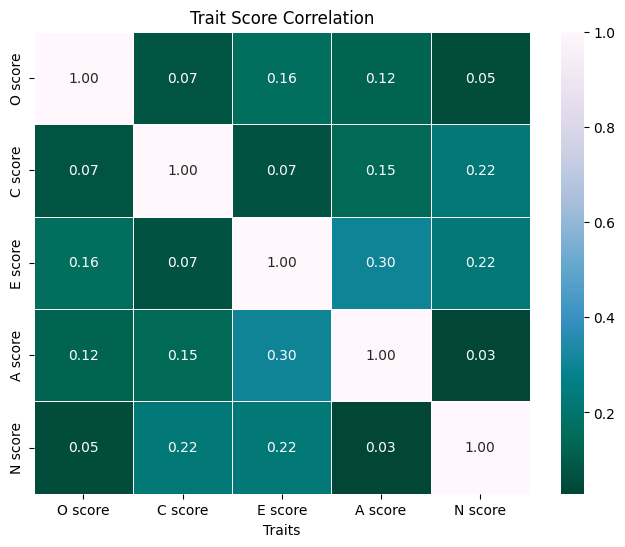

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the last 5 columns of 'data'
selected_cols = data.columns[-5:].tolist()

# Compute correlation matrix for the last 5 columns
answer_matrix_corr = data[selected_cols].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(answer_matrix_corr, annot=True, cmap="PuBuGn_r", fmt=".2f", linewidths=0.5)
plt.title("Trait Score Correlation")
plt.xlabel("Traits")
plt.ylabel("")
plt.show()


### Distrbution of Trait Scores

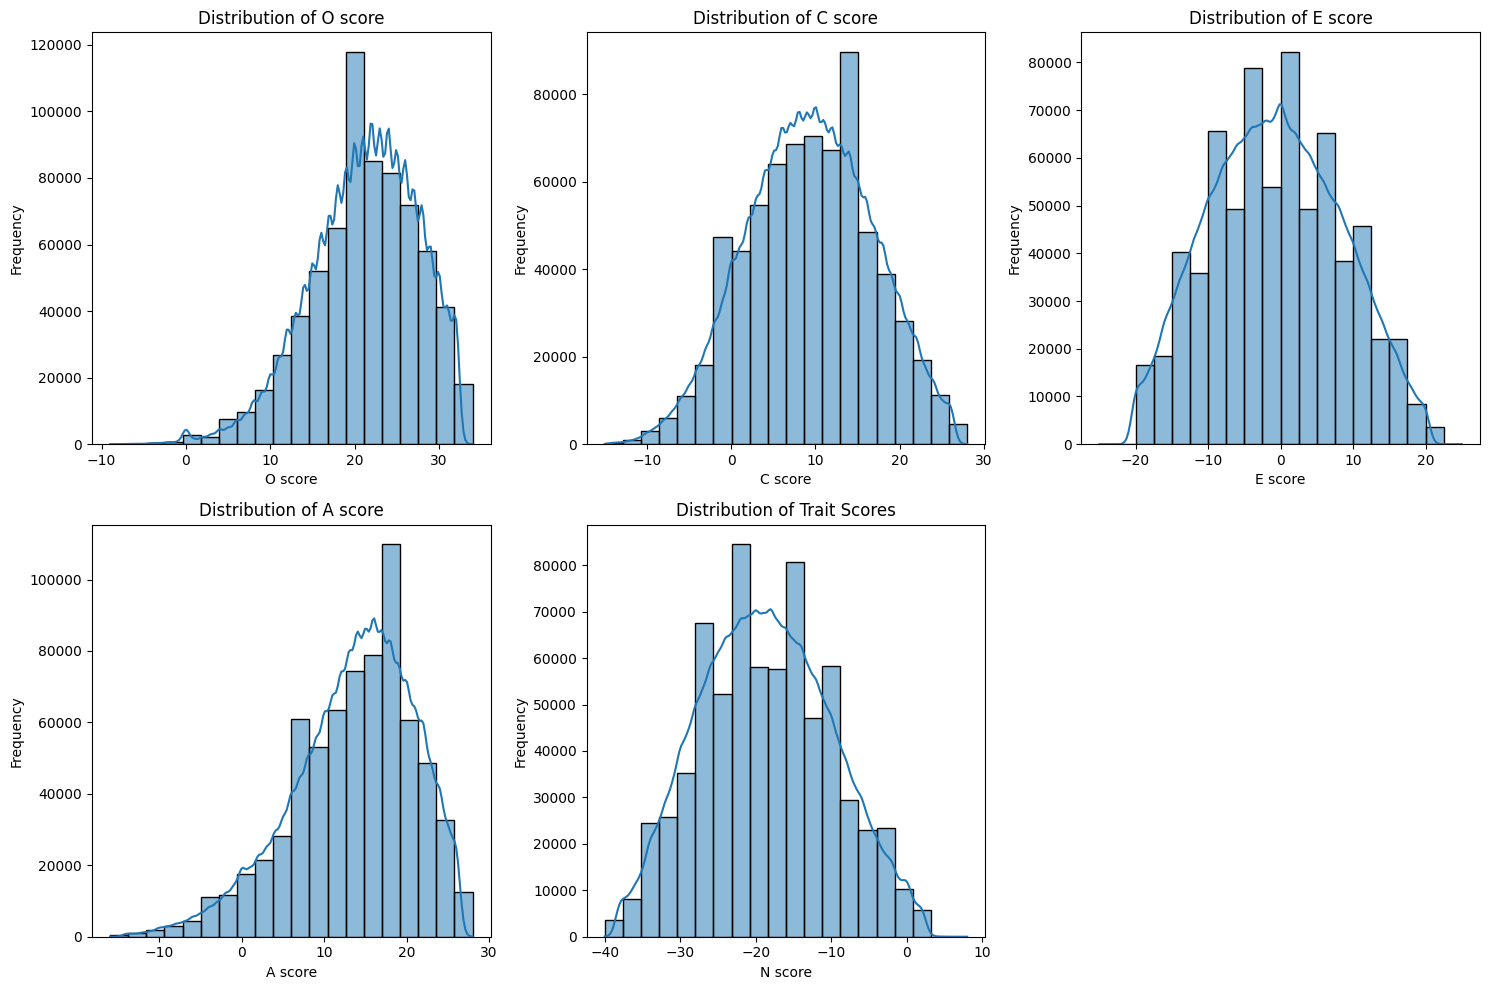

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

trait_scores = data.columns[-5:].tolist()

# Create a plot for each of the last 5 columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(selected_cols, 1):
    plt.subplot(2, 3, i)  # Create a grid of 2 rows and 3 columns
    sns.histplot(data[col], kde=True, bins=20)  # Use both histogram and KDE
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    sns.color_palette(palette='Oranges_d')
plt.title('Distribution of Trait Scores')
plt.tight_layout()
plt.show()


### Clustering Trait Scores

K-Means (15m:43s runtime)

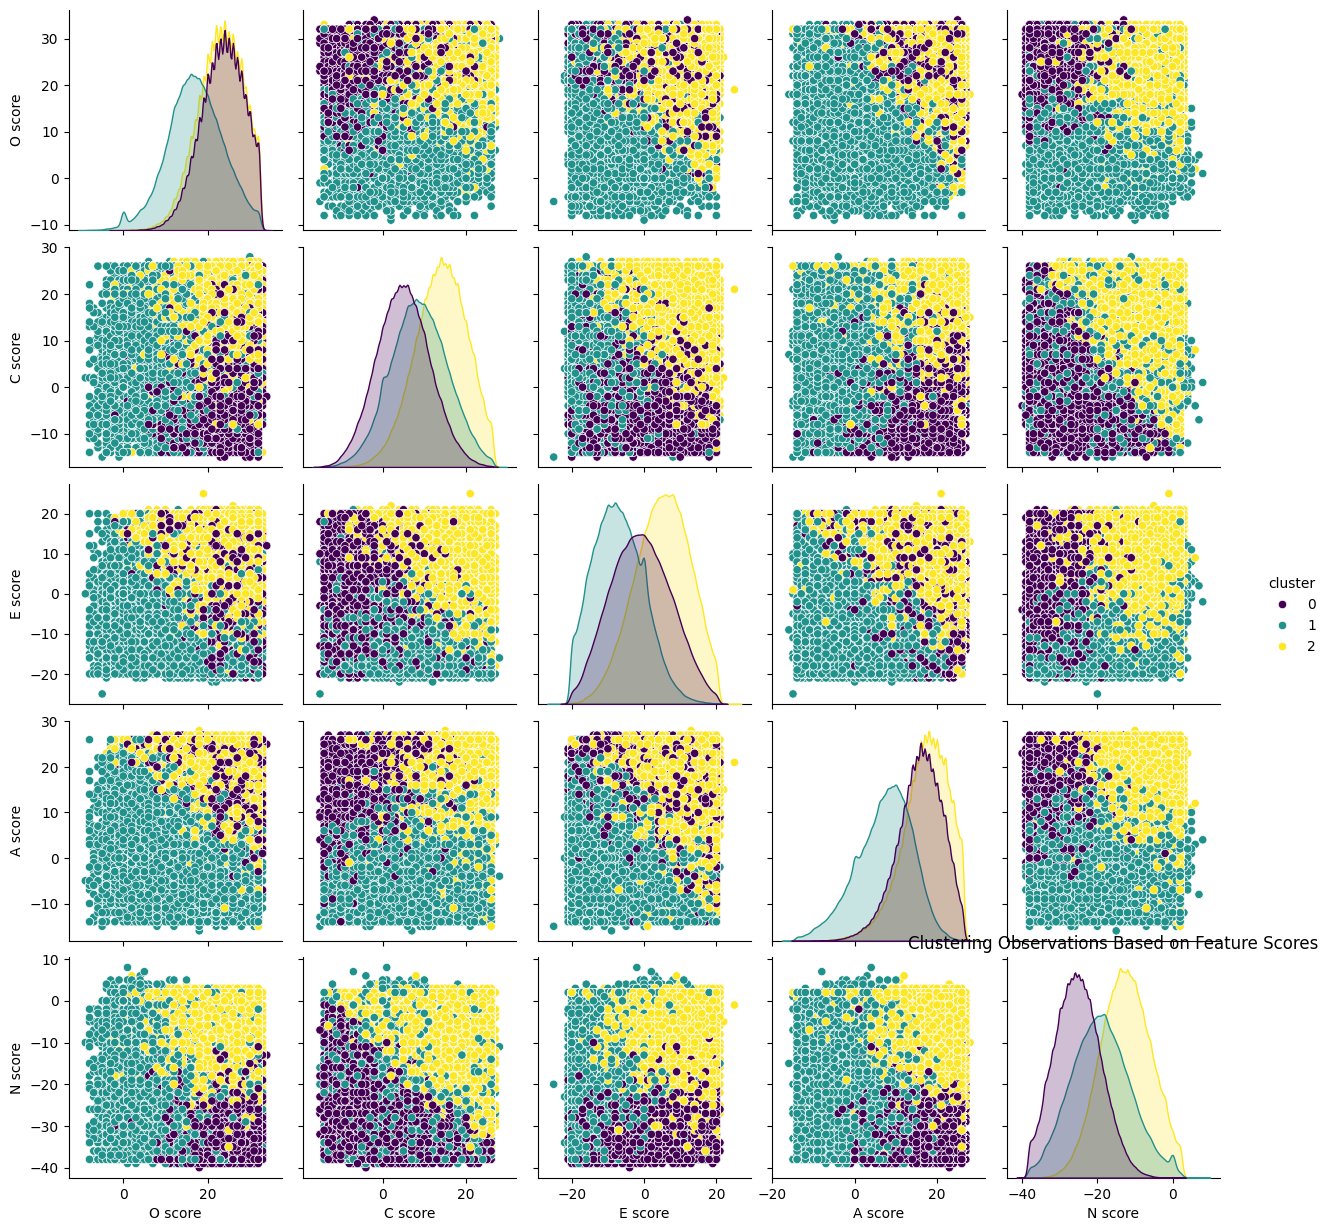

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Standardize the data (important for clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[selected_cols])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
data['cluster'] = kmeans.fit_predict(scaled_data)

# Plot the results
sns.pairplot(data, hue='cluster', vars=selected_cols, palette='viridis')
plt.title("Clustering Observations Based on Feature Scores")
plt.show()


PCA

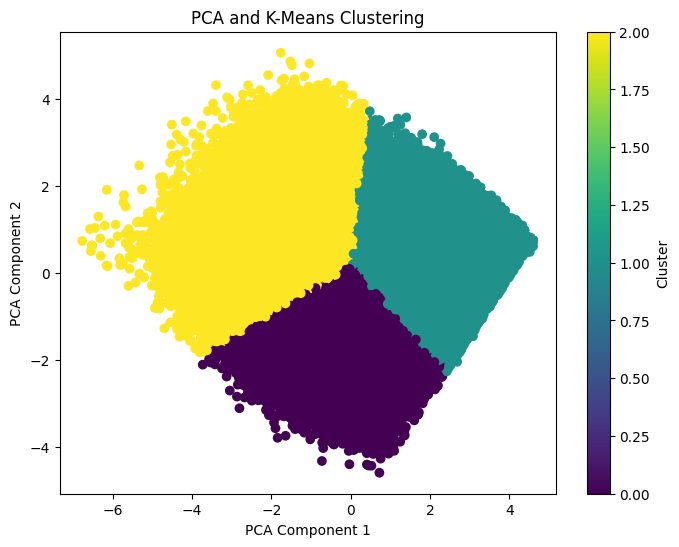

In [46]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Apply K-Means on the reduced dimensionality
kmeans = KMeans(n_clusters=3, random_state=42)
pca_clusters = kmeans.fit_predict(pca_components)

# Plot PCA + Clustering results
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=pca_clusters, cmap='viridis')
plt.title("PCA and K-Means Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


### Modeling for Country & Lat/Long

Remove rows with NaN values

In [55]:
data_clean = data.dropna()
data = data_clean

Model Evaluation ( > 9m runtime; did not complete this cell)

## TODO: Clustering of survey results; Modeling for Trait Scores using Survey Results; Geographic Visualization

In [69]:
import geodatasets
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))


Country Visualization (Attempt)

In [80]:
import plotly.express as px
import pycountry

# Function to convert ISO-2 to ISO-3
def iso_a2_to_a3(iso_a2):
    try:
        return pycountry.countries.get(alpha_2=iso_a2).alpha_3
    except AttributeError:
        return None  # Handle cases where conversion fails

# Convert ISO-2 to ISO-3
country_counts["iso_a3"] = country_counts["iso_a2"].apply(iso_a2_to_a3)

# Drop any rows where conversion failed
country_counts = country_counts.dropna(subset=["iso_a3"])

# Create a choropleth map using ISO-3 codes
fig = px.choropleth(
    country_counts,
    locations="iso_a3",
    locationmode="ISO-3",
    color="count",
    color_continuous_scale="viridis",
    title="Country Occurrences",
    projection="natural earth"
)

# Show the plot
fig.show()
